In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os

path = "/content/gdrive/My Drive/gpr_locate"
os.chdir(path)

In [0]:
# -*- coding: utf-8 -*-
"""
Class definition of YOLO_v3 style detection model on image and video
"""
import cv2
import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
from keras.utils import multi_gpu_model

class YOLO(object):
    _defaults = {
        "model_path": 'model_data/logs/trained_weights_final.h5',
        "anchors_path": 'model_data/yolo_anchors.txt',
        "classes_path": 'model_data/my_classes.txt',
        "score" : 0.3,
        "iou" : 0.45,
        "model_image_size" : (416, 416),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = os.path.expanduser(self.classes_path)
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def detect_image(self, image, path):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('Found {} boxes for {}'.format(len(out_boxes), path))

        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
            draw.rectangle(
                [tuple(text_origin), tuple(text_origin + label_size)],
                fill=self.colors[c])
            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        print(end - start)
        if len(out_boxes)>0:
            plt.imshow(image)
            plt.axis('off')
            plt.savefig('predicted_fig/'+path.replace('.png','_pre.png'))
            plt.show()
            
            img = cv2.imread('predict/'+path)
            img = img[top:bottom,left:right]
            cv2.imwrite('predicted_cut/'+path.replace('.png','_pre_cut.png'),img)

    def close_session(self):
        self.sess.close()


model_data/logs/trained_weights_final.h5 model, anchors, and classes loaded.
(416, 416, 3)
Found 1 boxes for coal113_merged.png
wave 0.98 (83, 694) (1906, 1131)
7.0922846979992755


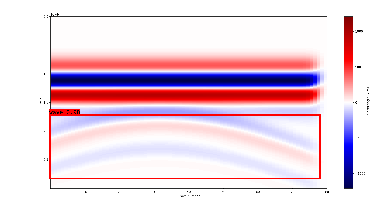

(416, 416, 3)
Found 1 boxes for coal115_merged.png
wave 1.00 (40, 768) (1939, 1179)
0.2772996029998467


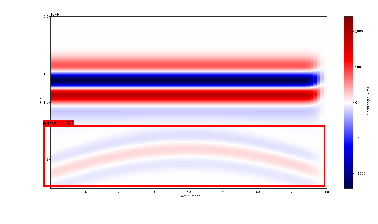

(416, 416, 3)
Found 1 boxes for coal116_merged.png
wave 0.99 (0, 898) (2103, 1186)
0.26019925999935367


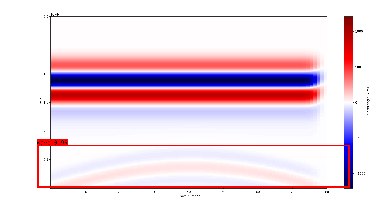

(416, 416, 3)
Found 1 boxes for coal114_merged.png
wave 0.99 (71, 690) (1913, 1150)
0.2585064329978195


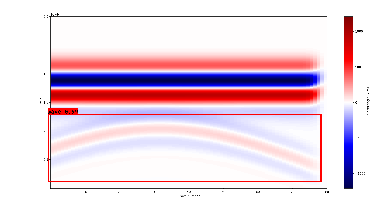

(416, 416, 3)
Found 1 boxes for coal117_merged.png
wave 0.99 (202, 605) (1734, 1074)
0.2588175119999505


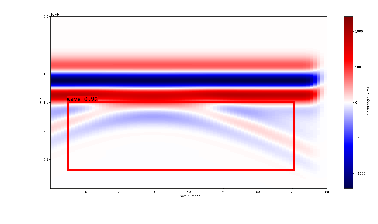

(416, 416, 3)
Found 1 boxes for coal118_merged.png
wave 1.00 (43, 749) (1924, 1187)
0.2592879730000277


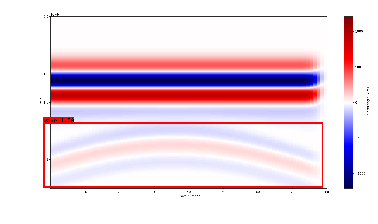

(416, 416, 3)
Found 1 boxes for coal124_merged.png
wave 1.00 (63, 772) (1896, 1183)
0.25844737399893347


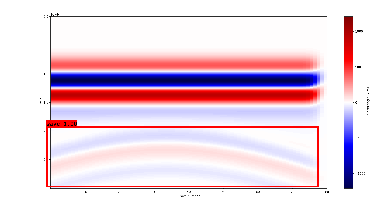

(416, 416, 3)
Found 1 boxes for coal120_merged.png
wave 1.00 (49, 758) (1917, 1182)
0.25545170799887273


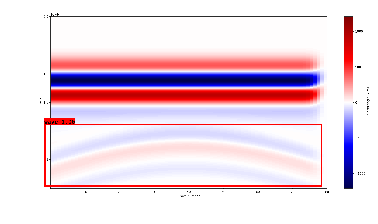

(416, 416, 3)
Found 1 boxes for coal121_merged.png
wave 0.99 (46, 693) (1934, 1160)
0.26334997699814267


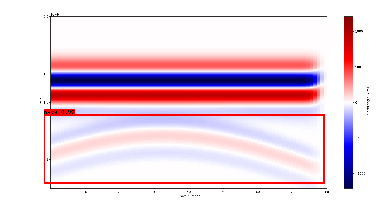

(416, 416, 3)
Found 1 boxes for coal122_merged.png
wave 0.97 (0, 904) (2107, 1190)
0.2612406589978491


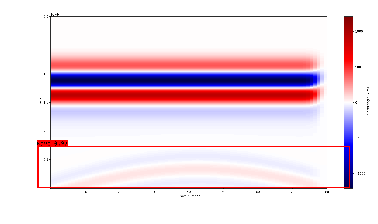

(416, 416, 3)
Found 1 boxes for coal123_merged.png
wave 0.98 (172, 616) (1805, 1110)
0.2553726500009361


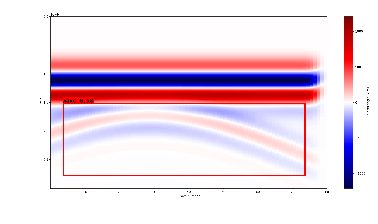

(416, 416, 3)
Found 1 boxes for coal119_merged.png
wave 0.98 (72, 687) (1922, 1137)
0.2663779920003435


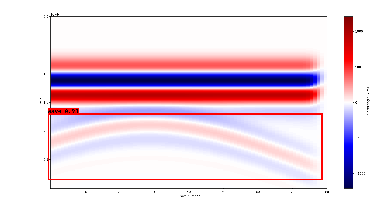

(416, 416, 3)
Found 1 boxes for coal125_merged.png
wave 1.00 (0, 874) (2007, 1186)
0.25777248599843006


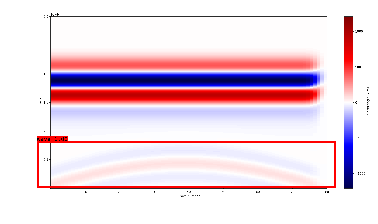

(416, 416, 3)
Found 1 boxes for coal50_merged.png
wave 0.98 (63, 682) (1918, 1135)
0.25452069400125765


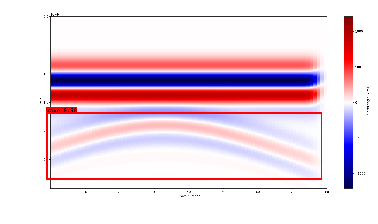

(416, 416, 3)
Found 1 boxes for coal51_merged.png
wave 0.99 (203, 614) (1754, 1083)
0.2702383230025589


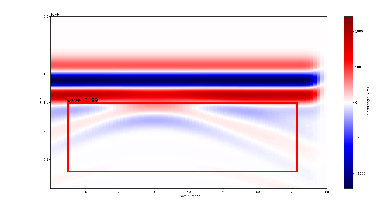

(416, 416, 3)
Found 1 boxes for coal57_merged.png
wave 0.97 (118, 542) (1879, 1184)
0.2594506050008931


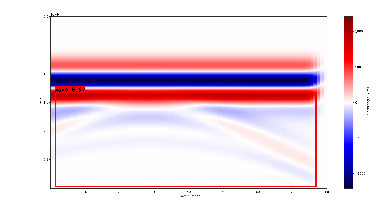

(416, 416, 3)
Found 1 boxes for coal56_merged.png
wave 0.98 (201, 552) (1762, 1167)
0.25471079199996893


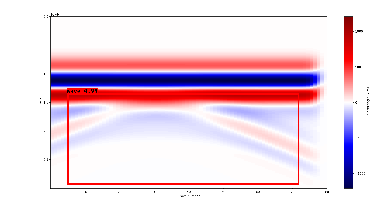

(416, 416, 3)
Found 1 boxes for coal54_merged.png
wave 0.98 (71, 690) (1907, 1134)
0.2561603419999301


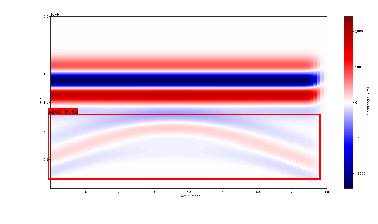

(416, 416, 3)
Found 1 boxes for coal55_merged.png
wave 0.99 (218, 615) (1755, 1105)
0.2570505840012629


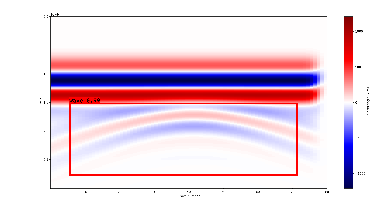

(416, 416, 3)
Found 1 boxes for coal53_merged.png
wave 1.00 (65, 696) (1917, 1151)
0.2554447490001621


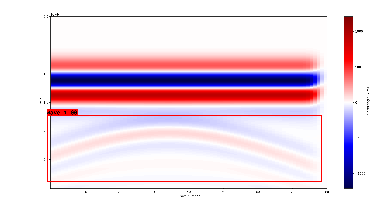

(416, 416, 3)
Found 1 boxes for coal52_merged.png
wave 1.00 (52, 751) (1938, 1166)
0.258426373002294


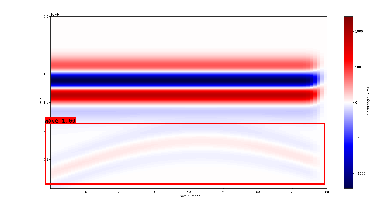

(416, 416, 3)
Found 1 boxes for coal58_merged.png
wave 0.99 (107, 704) (1896, 1125)
0.25454190600066795


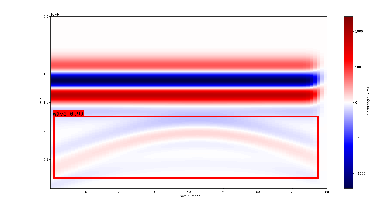

(416, 416, 3)
Found 1 boxes for coal59_merged.png
wave 0.99 (59, 681) (1910, 1143)
0.25765658199816244


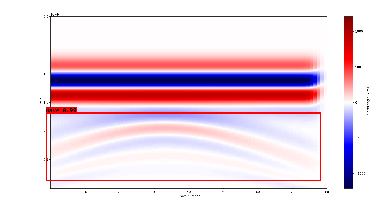

(416, 416, 3)
Found 1 boxes for coal60_merged.png
wave 0.99 (188, 612) (1787, 1114)
0.2582316410007479


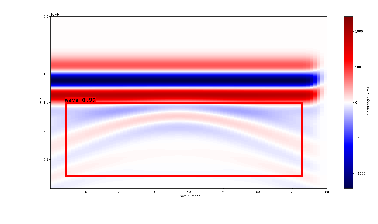

(416, 416, 3)
Found 1 boxes for coal61_merged.png
wave 0.99 (94, 686) (1902, 1136)
0.2598710560014297


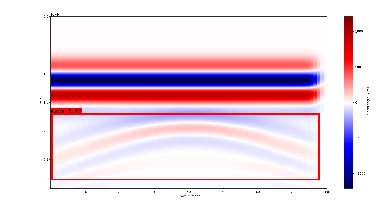

(416, 416, 3)
Found 1 boxes for free_space117_merged.png
wave 1.00 (211, 602) (1760, 1040)
0.2635616689985909


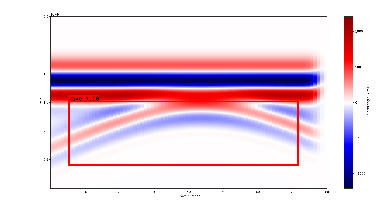

(416, 416, 3)
Found 1 boxes for coal62_merged.png
wave 0.98 (253, 611) (1718, 1084)
0.25761881099970196


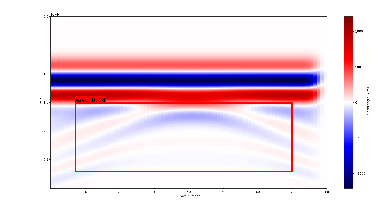

(416, 416, 3)
Found 1 boxes for free_space113_merged.png
wave 0.99 (185, 592) (1778, 1032)
0.25793381900075474


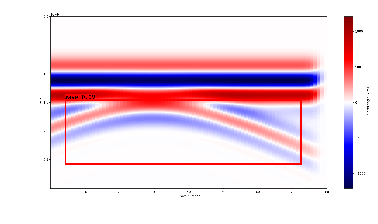

(416, 416, 3)
Found 1 boxes for free_space116_merged.png
wave 1.00 (69, 774) (1906, 1194)
0.26675003499985905


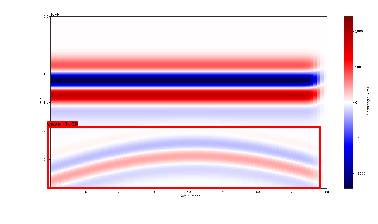

(416, 416, 3)
Found 1 boxes for free_space115_merged.png
wave 0.98 (56, 575) (1928, 1148)
0.25570830200013006


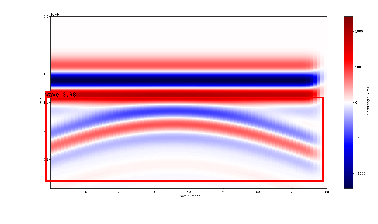

(416, 416, 3)
Found 1 boxes for free_space118_merged.png
wave 0.99 (174, 502) (1804, 1110)
0.25651846999971895


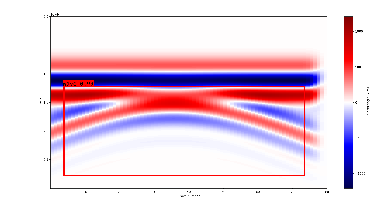

(416, 416, 3)
Found 1 boxes for free_space121_merged.png
wave 1.00 (44, 809) (1929, 1205)
0.25339310900017153


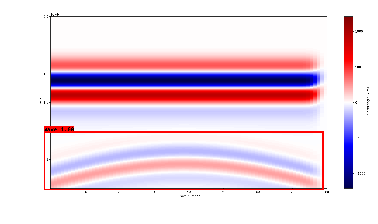

(416, 416, 3)
Found 1 boxes for free_space119_merged.png
wave 1.00 (27, 832) (1934, 1192)
0.2510603850023472


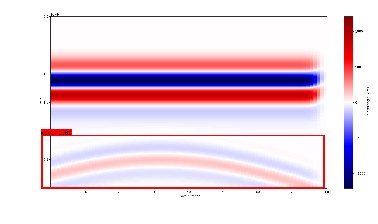

(416, 416, 3)
Found 1 boxes for free_space120_merged.png
wave 0.99 (103, 704) (1895, 1131)
0.25778089400046156


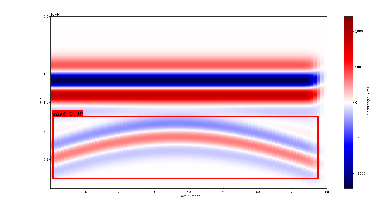

(416, 416, 3)
Found 1 boxes for free_space114_merged.png
wave 0.99 (174, 524) (1792, 1109)
0.2636433459992986


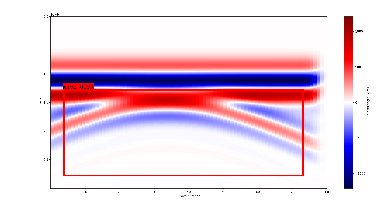

(416, 416, 3)
Found 1 boxes for free_space123_merged.png
wave 0.98 (172, 610) (1794, 1104)
0.25700699599838117


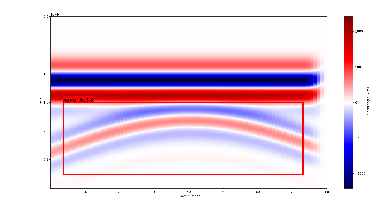

(416, 416, 3)
Found 1 boxes for free_space50_merged.png
wave 1.00 (130, 537) (1850, 1139)
0.256915478999872


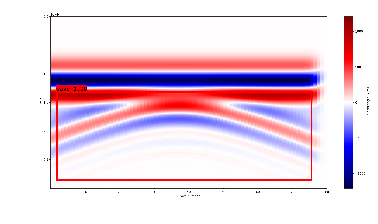

(416, 416, 3)
Found 1 boxes for free_space122_merged.png
wave 1.00 (63, 769) (1908, 1190)
0.26187699000001885


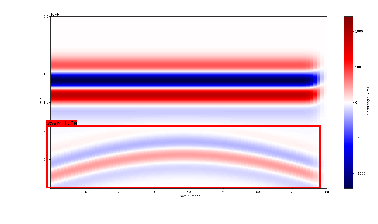

(416, 416, 3)
Found 1 boxes for free_space125_merged.png
wave 1.00 (55, 724) (1931, 1175)
0.2565444559986645


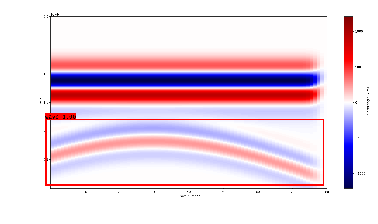

(416, 416, 3)
Found 1 boxes for free_space124_merged.png
wave 0.98 (180, 612) (1791, 1103)
0.26172974400105886


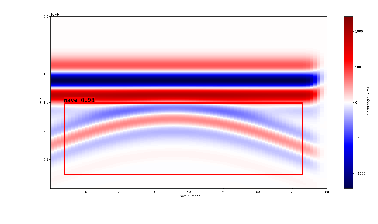

(416, 416, 3)
Found 1 boxes for free_space53_merged.png
wave 0.98 (179, 546) (1787, 1178)
0.27132748999792966


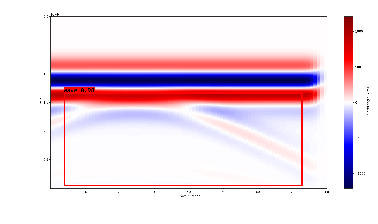

(416, 416, 3)
Found 1 boxes for free_space54_merged.png
wave 0.97 (196, 630) (1781, 1121)
0.2762265640012629


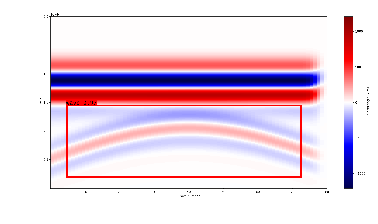

(416, 416, 3)
Found 1 boxes for free_space51_merged.png
wave 1.00 (68, 743) (1896, 1185)
0.26347214199995506


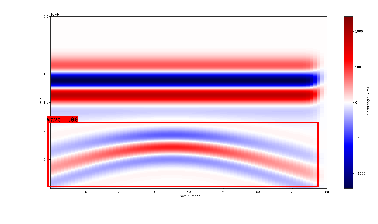

(416, 416, 3)
Found 1 boxes for free_space55_merged.png
wave 0.97 (178, 620) (1804, 1111)
0.2648998799995752


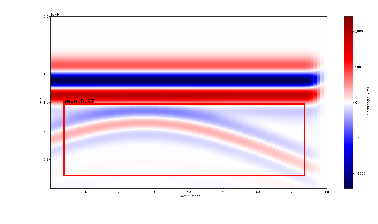

(416, 416, 3)
Found 1 boxes for free_space52_merged.png
wave 1.00 (89, 530) (1882, 1159)
0.256552353999723


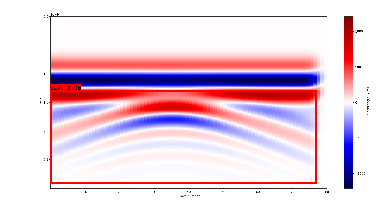

(416, 416, 3)
Found 1 boxes for free_space56_merged.png
wave 0.99 (138, 569) (1837, 1159)
0.2574810320002143


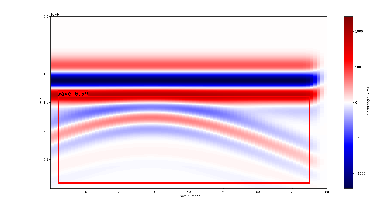

(416, 416, 3)
Found 1 boxes for free_space60_merged.png
wave 1.00 (60, 719) (1911, 1156)
0.2558001110010082


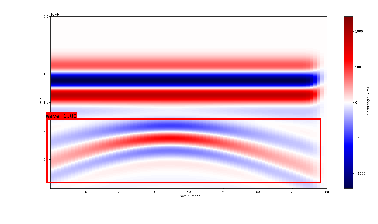

(416, 416, 3)
Found 1 boxes for free_space59_merged.png
wave 0.99 (218, 616) (1741, 1072)
0.26037192899821093


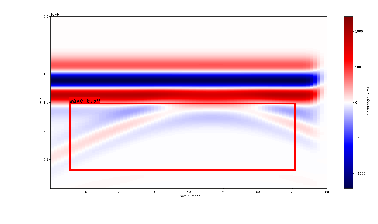

(416, 416, 3)
Found 1 boxes for free_space58_merged.png
wave 0.97 (178, 628) (1804, 1120)
0.2543912020009884


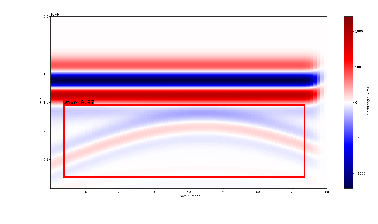

(416, 416, 3)
Found 1 boxes for free_space57_merged.png
wave 0.98 (148, 630) (1835, 1108)
0.2555928559995664


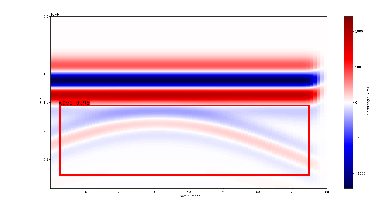

(416, 416, 3)
Found 1 boxes for free_space62_merged.png
wave 0.98 (89, 564) (1883, 1158)
0.26110540499939816


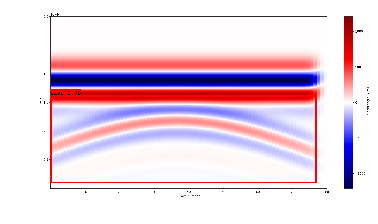

(416, 416, 3)
Found 1 boxes for pec113_merged.png
wave 1.00 (108, 497) (1841, 1120)
0.2649444050002785


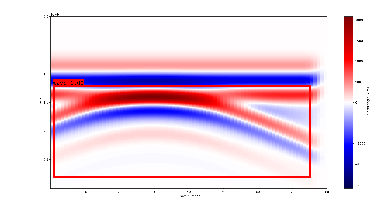

(416, 416, 3)
Found 1 boxes for free_space61_merged.png
wave 0.97 (59, 574) (1927, 1155)
0.2567207119973318


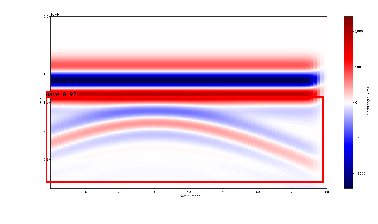

(416, 416, 3)
Found 1 boxes for pec114_merged.png
wave 1.00 (147, 471) (1806, 1097)
0.2586886739991314


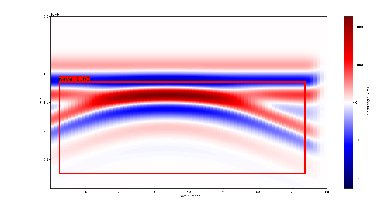

(416, 416, 3)
Found 1 boxes for pec115_merged.png
wave 0.99 (38, 588) (1941, 1146)
0.2687701899994863


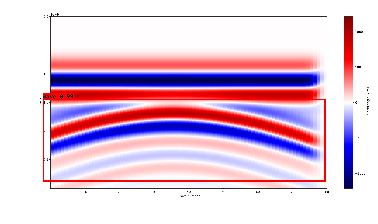

(416, 416, 3)
Found 1 boxes for pec117_merged.png
wave 1.00 (125, 496) (1852, 1108)
0.2525620929991419


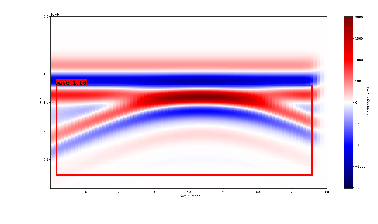

(416, 416, 3)
Found 1 boxes for pec120_merged.png
wave 0.96 (68, 630) (1898, 1191)
0.25952270399648114


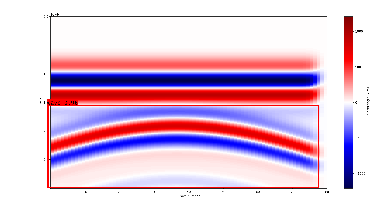

(416, 416, 3)
Found 1 boxes for pec116_merged.png
wave 1.00 (67, 759) (1907, 1181)
0.2570223310030997


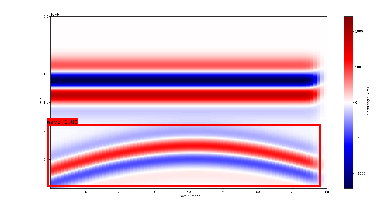

(416, 416, 3)
Found 1 boxes for pec118_merged.png
wave 1.00 (138, 485) (1828, 1112)
0.2550296880035603


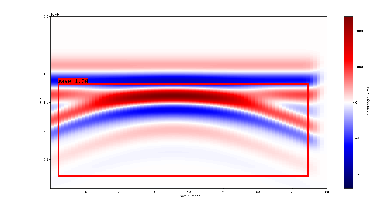

(416, 416, 3)
Found 1 boxes for pec119_merged.png
wave 1.00 (89, 800) (1860, 1187)
0.2546322070011229


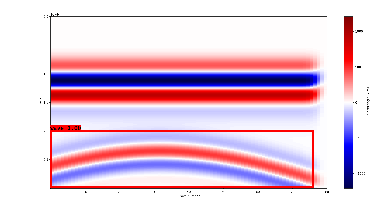

(416, 416, 3)
Found 1 boxes for pec123_merged.png
wave 0.99 (67, 577) (1912, 1160)
0.25417699299941887


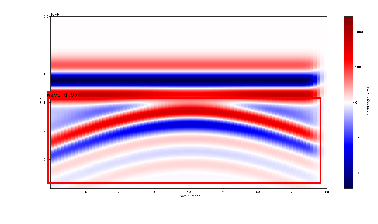

(416, 416, 3)
Found 1 boxes for pec125_merged.png
wave 0.98 (113, 709) (1854, 1131)
0.255202513999393


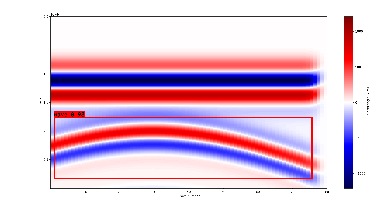

(416, 416, 3)
Found 1 boxes for pec124_merged.png
wave 0.99 (77, 580) (1896, 1146)
0.25841070000024047


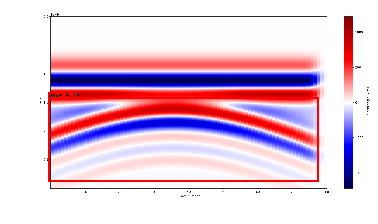

(416, 416, 3)
Found 1 boxes for pec122_merged.png
wave 1.00 (72, 741) (1890, 1174)
0.27322581299813464


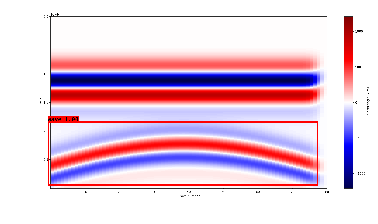

(416, 416, 3)
Found 1 boxes for pec121_merged.png
wave 1.00 (88, 796) (1882, 1193)
0.2546512299995811


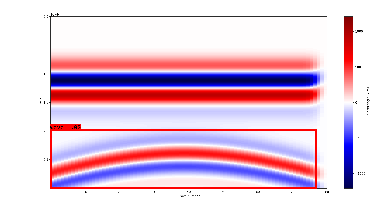

(416, 416, 3)
Found 1 boxes for pec51_merged.png
wave 0.99 (47, 727) (1916, 1152)
0.2589271409997309


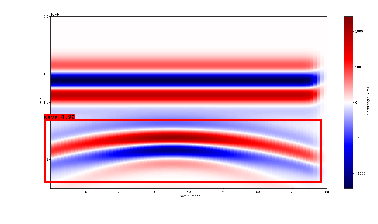

(416, 416, 3)
Found 1 boxes for pec56_merged.png
wave 0.99 (77, 584) (1896, 1144)
0.265112084998691


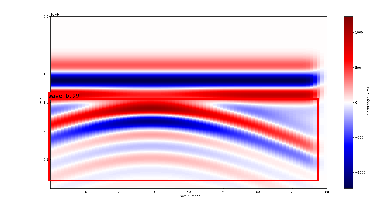

(416, 416, 3)
Found 1 boxes for pec53_merged.png
wave 1.00 (147, 516) (1778, 1113)
0.25564584499807097


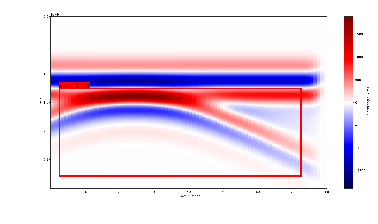

(416, 416, 3)
Found 1 boxes for pec52_merged.png
wave 0.99 (113, 548) (1844, 1127)
0.2625749939979869


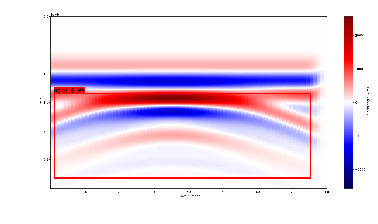

(416, 416, 3)
Found 1 boxes for pec50_merged.png
wave 1.00 (122, 519) (1845, 1127)
0.2635720729995228


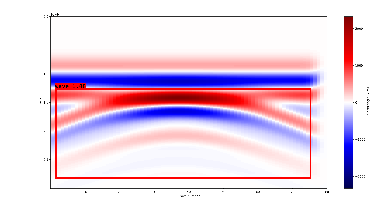

(416, 416, 3)
Found 1 boxes for pec59_merged.png
wave 0.99 (148, 527) (1824, 1105)
0.2531717629972263


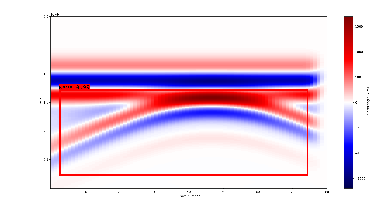

(416, 416, 3)
Found 1 boxes for pec55_merged.png
wave 0.98 (43, 599) (1936, 1145)
0.26125204200070584


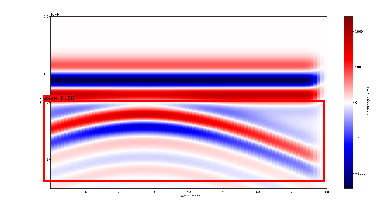

(416, 416, 3)
Found 1 boxes for pec58_merged.png
wave 0.98 (62, 568) (1918, 1180)
0.2533297410009254


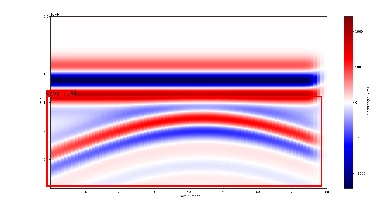

(416, 416, 3)
Found 1 boxes for pec54_merged.png
wave 0.97 (12, 582) (1967, 1166)
0.2524520560000383


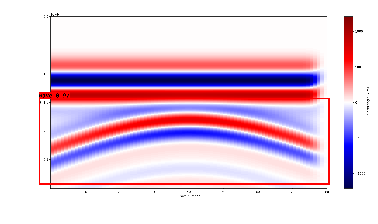

(416, 416, 3)
Found 1 boxes for pec57_merged.png
wave 0.99 (74, 593) (1897, 1146)
0.2563024650007719


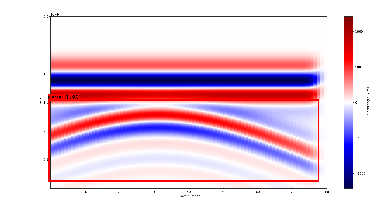

(416, 416, 3)
Found 1 boxes for pec60_merged.png
wave 0.99 (67, 707) (1906, 1146)
0.25306903799719294


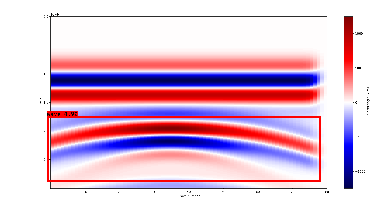

(416, 416, 3)
Found 1 boxes for soil113_merged.png
wave 0.97 (89, 631) (1861, 1195)
0.251865190002718


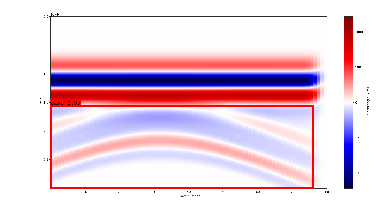

(416, 416, 3)
Found 1 boxes for pec61_merged.png
wave 0.98 (36, 600) (1941, 1143)
0.25536334199932753


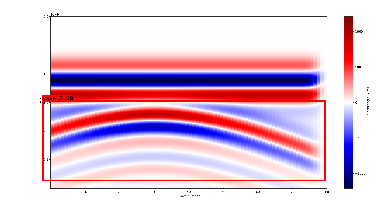

(416, 416, 3)
Found 1 boxes for pec62_merged.png
wave 0.99 (53, 584) (1928, 1152)
0.25471364699842525


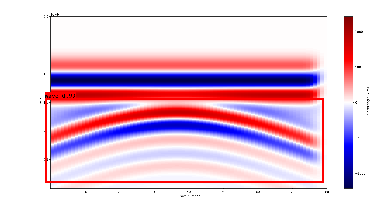

(416, 416, 3)
Found 1 boxes for soil114_merged.png
wave 0.97 (0, 559) (1993, 1187)
0.2535473300013109


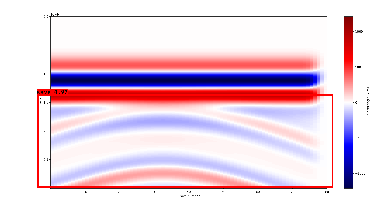

(416, 416, 3)
Found 1 boxes for soil119_merged.png
wave 0.97 (25, 560) (1952, 1183)
0.2657085089995235


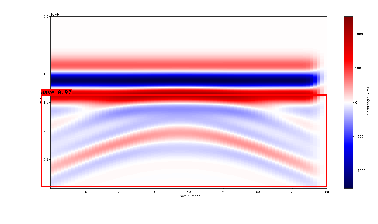

(416, 416, 3)
Found 1 boxes for soil117_merged.png
wave 1.00 (51, 819) (1919, 1189)
0.2542743589983729


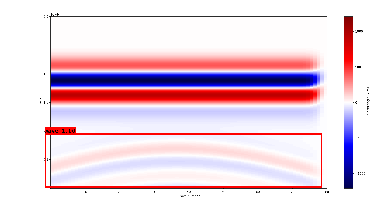

(416, 416, 3)
Found 1 boxes for soil118_merged.png
wave 1.00 (12, 694) (1970, 1173)
0.25577771900134394


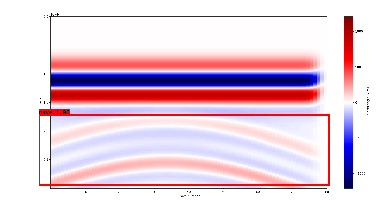

(416, 416, 3)
Found 1 boxes for soil116_merged.png
wave 0.96 (100, 625) (1857, 1200)
0.26756874099737615


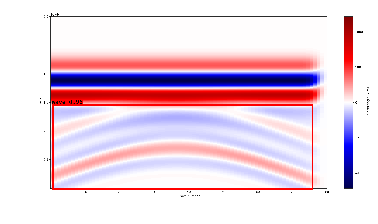

(416, 416, 3)
Found 1 boxes for soil115_merged.png
wave 0.99 (78, 689) (1918, 1144)
0.2583009940026386


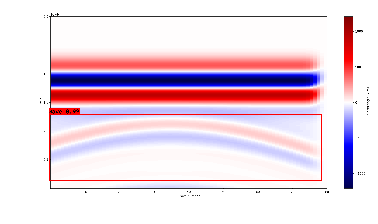

(416, 416, 3)
Found 1 boxes for soil120_merged.png
wave 1.00 (22, 743) (1925, 1216)
0.2553535670012934


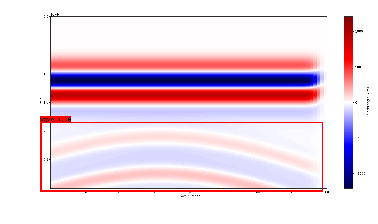

(416, 416, 3)
Found 1 boxes for soil121_merged.png
wave 1.00 (0, 847) (1983, 1184)
0.25540965300024254


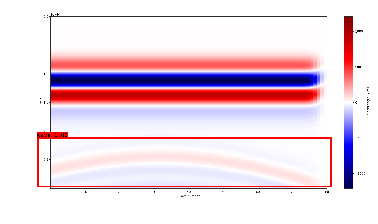

(416, 416, 3)
Found 1 boxes for soil122_merged.png
wave 0.97 (83, 641) (1849, 1173)
0.25213195999822346


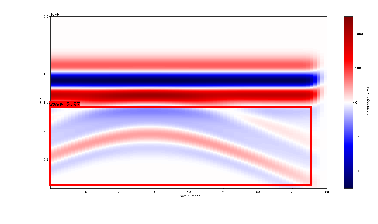

(416, 416, 3)
Found 1 boxes for soil123_merged.png
wave 0.95 (69, 567) (1907, 1173)
0.2551917130003858


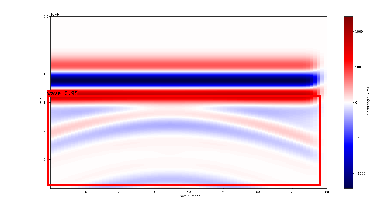

(416, 416, 3)
Found 1 boxes for soil124_merged.png
wave 0.97 (132, 622) (1836, 1203)
0.26376463300039177


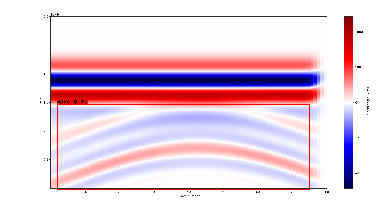

(416, 416, 3)
Found 1 boxes for soil51_merged.png
wave 0.99 (85, 694) (1908, 1154)
0.2577681680013484


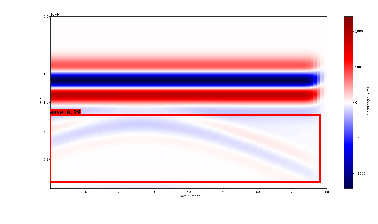

(416, 416, 3)
Found 1 boxes for soil53_merged.png
wave 0.99 (64, 692) (1881, 1181)
0.2506812940009695


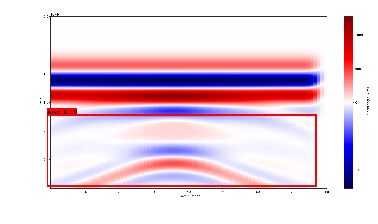

(416, 416, 3)
Found 1 boxes for soil52_merged.png
wave 1.00 (47, 708) (1924, 1202)
0.2557471359978081


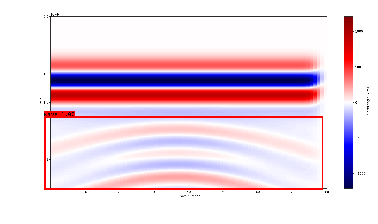

(416, 416, 3)
Found 1 boxes for soil50_merged.png
wave 1.00 (16, 689) (1942, 1162)
0.2586237750001601


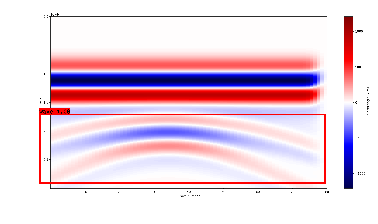

(416, 416, 3)
Found 1 boxes for soil125_merged.png
wave 1.00 (10, 692) (1958, 1182)
0.2611402399998042


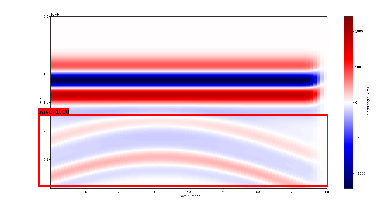

(416, 416, 3)
Found 1 boxes for soil56_merged.png
wave 1.00 (28, 795) (1934, 1195)
0.2565771709996625


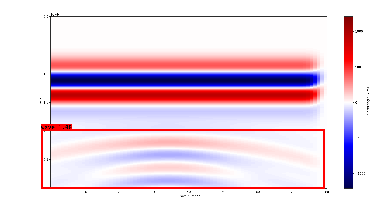

(416, 416, 3)
Found 1 boxes for soil54_merged.png
wave 1.00 (53, 822) (1888, 1206)
0.25572483200085117


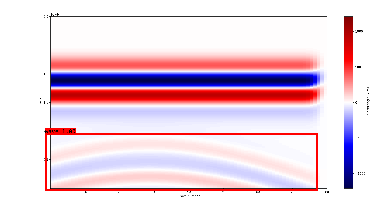

(416, 416, 3)
Found 1 boxes for soil55_merged.png
wave 1.00 (42, 705) (1920, 1202)
0.26292545400065137


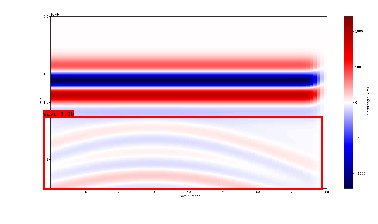

(416, 416, 3)
Found 1 boxes for soil57_merged.png
wave 0.97 (75, 689) (1889, 1149)
0.25492865100022755


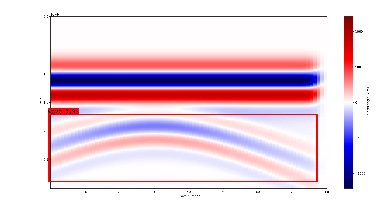

(416, 416, 3)
Found 1 boxes for soil58_merged.png
wave 1.00 (18, 692) (1955, 1194)
0.2582286249999015


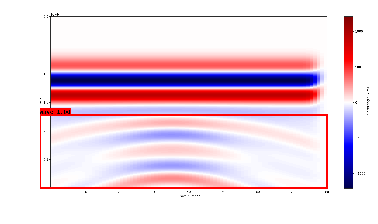

(416, 416, 3)
Found 1 boxes for soil61_merged.png
wave 0.99 (70, 696) (1922, 1167)
0.2556330719999096


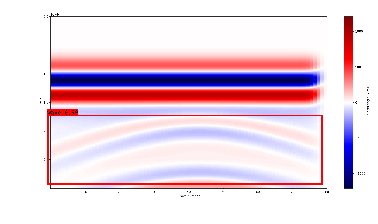

(416, 416, 3)
Found 1 boxes for soil59_merged.png
wave 0.99 (76, 543) (1913, 1196)
0.2655887979999534


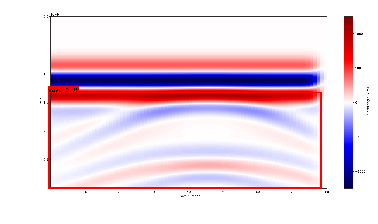

(416, 416, 3)
Found 1 boxes for soil60_merged.png
wave 0.99 (95, 690) (1893, 1155)
0.25658370800010744


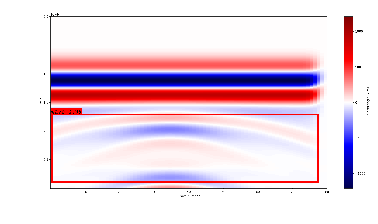

(416, 416, 3)
Found 1 boxes for soil62_merged.png
wave 0.98 (166, 616) (1800, 1201)
0.2564576910008327


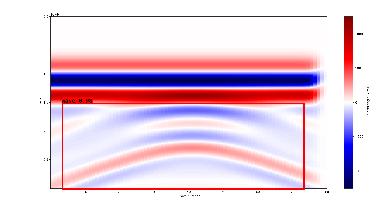

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

if __name__ == '__main__':
    yolo=YOLO()
    for path in os.listdir('predict'):
        image = Image.open('predict/'+path)
        yolo.detect_image(image,path)